In [1]:
import torch
import gpytorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"

from tqdm.notebook import tqdm

## 12.1 Training a Gaussian process on a large data set

### 12.1.1 Setting up the learning task

In [2]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief(model, likelihood, variational=False):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

    plt.figure(figsize=(8, 6))

    plt.plot(xs, ys, label="objective", c="r")
    if not variational:
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

    plt.plot(xs, predictive_mean, label="mean")
    plt.fill_between(
        xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
    )

    if variational:
        plt.scatter(
            train_x, train_y, marker="x", c="k", alpha=0.1, label="observations"
        )

        inducing_points = model.variational_strategy.inducing_points.detach().clone()
        with torch.no_grad():
            inducing_mean = model(inducing_points).mean

        plt.scatter(
            inducing_points.squeeze(-1),
            inducing_mean,
            marker="D",
            c="orange",
            s=100,
            label="inducing pts",
        )

    plt.legend(fontsize=15)
    plt.ylim(-10, 15)

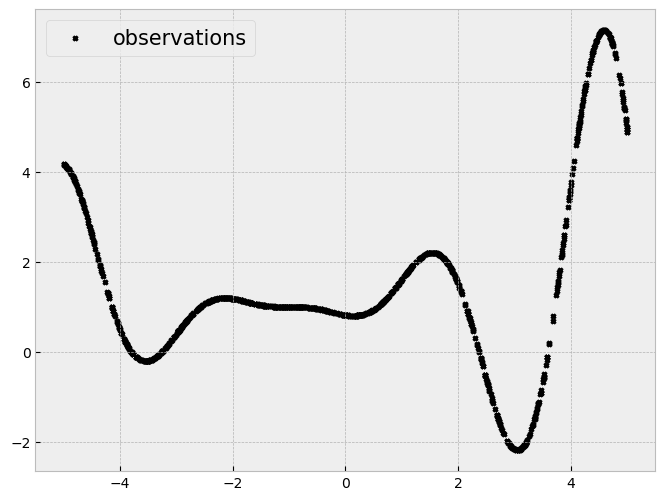

In [3]:
xs = torch.linspace(-7.5, 7.5, 151).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(0)
train_x = torch.rand(size=(1000, 1)) * 10 - 5
train_y = forrester_1d(train_x)

plt.figure(figsize=(8, 6))
plt.scatter(train_x, train_y, c="k", marker="x", s=10, label="observations")
plt.legend(fontsize=15);

### 12.1.2 Training a regular Gaussian process

In [4]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# declare the GP
lengthscale = 1
outputscale = 5
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [6]:
# train the hyperparameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(150)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/150 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8140097856521606 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7995691299438477 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/quannguyen/anaconda3/envs/gp_bo_new

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### 12.1.3 Problems with training a regular Gaussian process

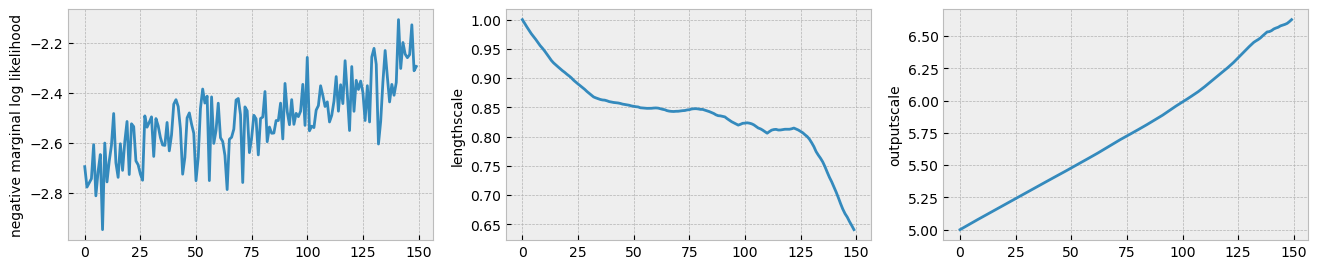

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale");

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.06457312405109406 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


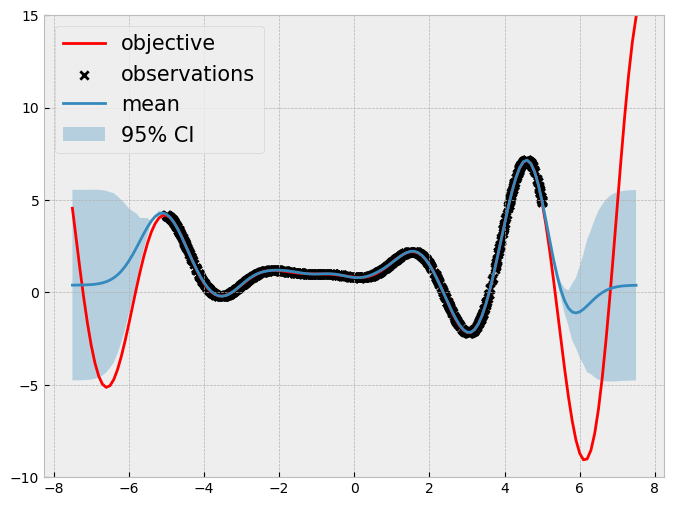

In [8]:
visualize_gp_belief(model, likelihood)

### 12.2.3 Implementing the approximate model

In [9]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

# declare the GP
lengthscale = 1
outputscale = 5
noise = 1e-4

model = ApproximateGPModel(train_x[:50, :])
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
likelihood.noise = noise

In [11]:
optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr=0.01
)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(15)):
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()

        output = model(x_batch)
        loss = -mll(output, y_batch)

        loss.backward()

        losses.append(loss.item())
        lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
        outputscales.append(model.covar_module.outputscale.item())

        optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/15 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

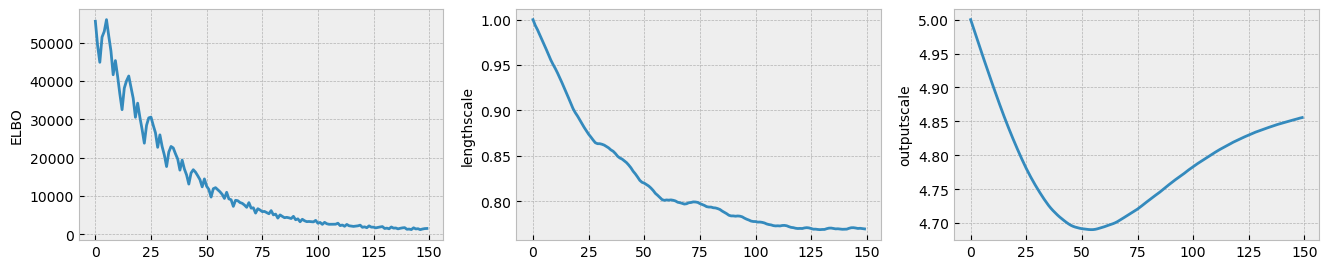

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(losses)
ax[0].set_ylabel("ELBO")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale");

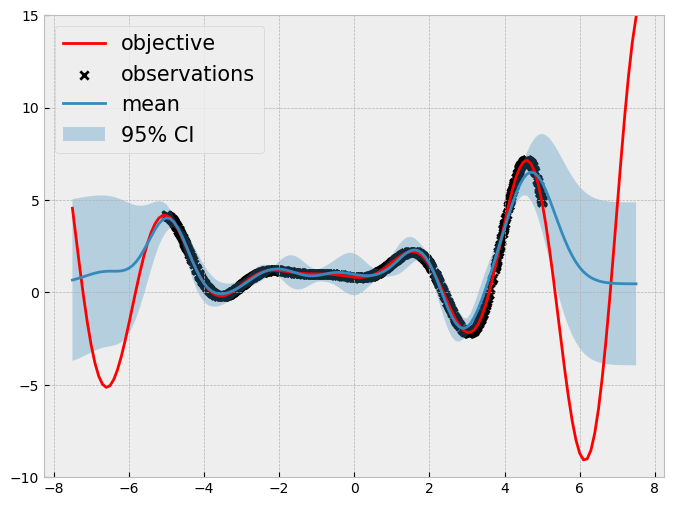

In [13]:
visualize_gp_belief(model, likelihood)

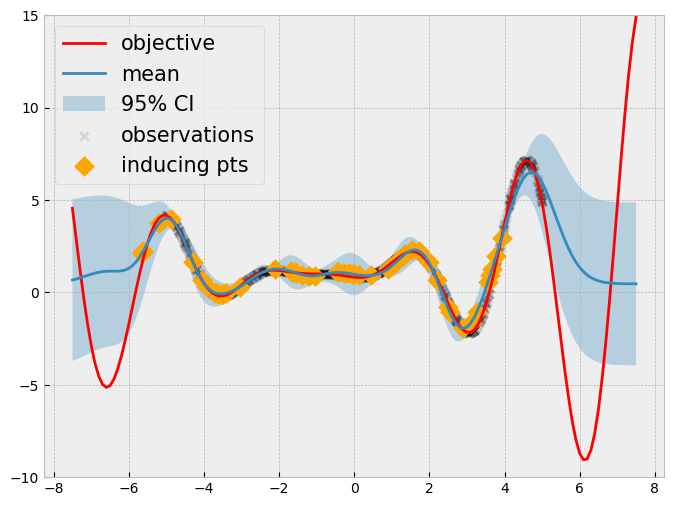

In [14]:
visualize_gp_belief(model, likelihood, variational=True)

## 12.3 Optimizing better by accounting for the geometry of the loss surface

In [15]:
class NaturalGradientGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
# declare the GP
lengthscale = 1
outputscale = 5
noise = 1e-4

model = NaturalGradientGPModel(train_x[:50, :])
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# fix the hyperparameters
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
likelihood.noise = noise

In [17]:
ngd_optimizer = gpytorch.optim.NGD(
    model.variational_parameters(), num_data=train_y.size(0), lr=0.1
)
hyperparam_optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr=0.01
)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

In [18]:
model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(15)):
    for x_batch, y_batch in train_loader:
        ngd_optimizer.zero_grad()
        hyperparam_optimizer.zero_grad()

        output = model(x_batch)
        loss = -mll(output, y_batch)

        loss.backward()

        losses.append(loss.item())
        lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
        outputscales.append(model.covar_module.outputscale.item())

        ngd_optimizer.step()
        hyperparam_optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/15 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

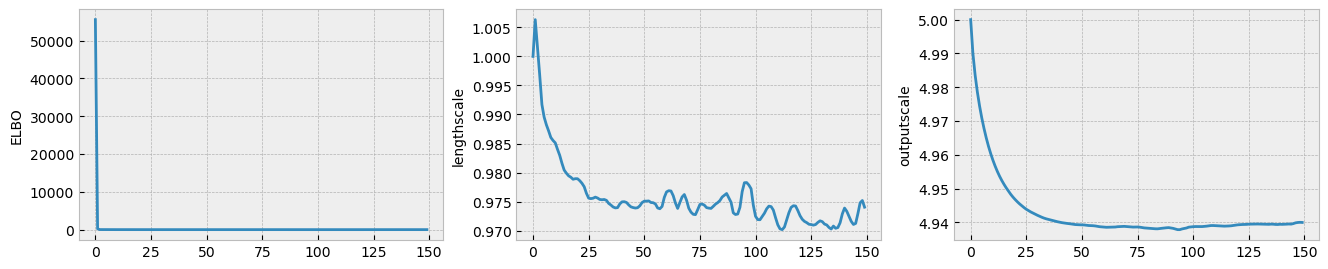

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(losses)
ax[0].set_ylabel("ELBO")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale");

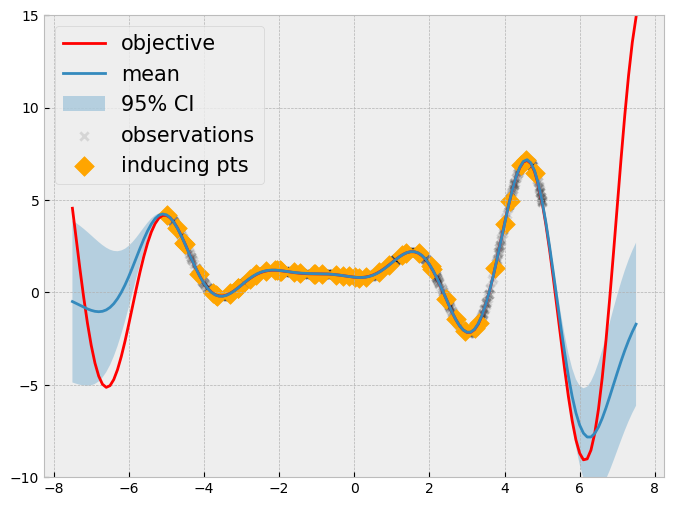

In [20]:
visualize_gp_belief(model, likelihood, variational=True)